In [11]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")

import pickle
import time

import torch

import matplotlib.pyplot as plt
import defmod as dm
import model_graddesc as model
import defmod.registrationdata as regdata

torch.set_default_tensor_type(torch.DoubleTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
source_vertices = torch.tensor([[1.,5.],[5.,5.],[8.,6.]])
target_vertices = torch.tensor([[1.,7.],[5.,5.],[8.,6.]])
nb_pts = [4,4]

data = regdata.part_rigid(source_vertices, target_vertices, nb_pts)
data.build_source()
#data.build_target()
data.build_shot_target()
data.build_modules()

source = data.source[0]
target = data.target[0]

In [18]:
dty = torch.float64

sigma_scaling = 1.

#%%

#gd0 = torch.tensor([[-1., 0.6]], requires_grad=True, dtype=dty)
gd0 = torch.tensor([[-1., 0.]], requires_grad=True, dtype=dty)
cotan0 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#gd1 = torch.tensor([[0.8, 0.6]], requires_grad=True, dtype=dty)
gd1 = torch.tensor([[1., 0.]], requires_grad=True, dtype=dty)
cotan1 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#%%

In [19]:
# Local Constraint Translation - Scaling
scaling_L0 = dm.deformationmodules.LocalScaling(dm.manifold.Landmarks(2, 1, gd = gd0.view(-1), cotan = cotan0.view(-1)),sigma_scaling)
scaling_L1 = dm.deformationmodules.LocalScaling(dm.manifold.Landmarks(2, 1, gd = gd1.view(-1), cotan = cotan1.view(-1)), sigma_scaling)

In [20]:
# Constraint Translation - Scaling
sigma_scaling = 1.
a = torch.sqrt(torch.tensor(3.))
direc_scaling_pts = torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=dty)
direc_scaling_vec =  torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=dty)
def f(x):
    centre = x.view(1,2).repeat(3,1)
    return centre + 0.3 * sigma_scaling * direc_scaling_pts

def g(x):
    return direc_scaling_vec
#%%
#gd0 = torch.tensor([[-1., 0.6]], requires_grad=True, dtype=dty)
gd0 = torch.tensor([[-1., 0.]], requires_grad=True, dtype=dty)
cotan0 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#gd1 = torch.tensor([[0.8, 0.6]], requires_grad=True, dtype=dty)
gd1 = torch.tensor([[1., 0.]], requires_grad=True, dtype=dty)
cotan1 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#%%
pts = f(gd0).detach().numpy()
vec = g(gd0).detach().numpy()
pts1 = f(gd1).detach().numpy()
vec1 = g(gd1).detach().numpy()


plt.quiver(pts[:,0], pts[:,1], vec[:,0], vec[:,1])
plt.quiver(pts1[:,0], pts1[:,1], vec1[:,0], vec1[:,1])
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], 'b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'r')
plt.axis('equal')
#%%
scaling0 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = gd0.view(-1), cotan = cotan0.view(-1)), f, g, sigma_scaling)
scaling1 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = gd1.view(-1), cotan = cotan1.view(-1)), f, g, sigma_scaling)


In [47]:
scaling0.fill_controls(torch.tensor([1.]))

In [49]:
h1 = dm.hamiltonian.Hamiltonian([scaling0])
h2 = dm.hamiltonian.Hamiltonian([scaling_L0])

In [59]:
points = target
nb_pts = len(points)
man = dm.manifold.Landmarks(2, nb_pts, gd = points.view(-1))

scaling0.manifold.fill_cotan(torch.tensor([10.,10.]))
scaling0.compute_geodesic_control(man)

scaling_L0.manifold.fill_cotan(torch.tensor([10.,10.]))
scaling_L0.compute_geodesic_control(man)


In [60]:
h1.geodesic_controls()
h1.module.controls

[tensor(-2.2204e-15, grad_fn=<MulBackward0>)]

In [61]:
h2.geodesic_controls()
h2.module.controls

[tensor([0.], grad_fn=<ViewBackward>)]

In [65]:
scaling0.fill_controls(torch.tensor([100.]))
scaling_L0.fill_controls(torch.tensor([100.]))

In [66]:
scaling0.field_generator()(points)

tensor([[ 1.0108e-11,  2.3353e-12],
        [ 5.7571e-13,  1.7101e-13],
        [ 2.2961e-14,  8.7772e-15],
        [ 1.3705e-13,  1.3116e-13],
        [ 1.9000e-12,  7.0392e-12],
        [-2.4038e-11,  2.0064e-10],
        [-8.7939e-10,  1.1392e-08],
        [-1.3115e-08,  8.4547e-07],
        [ 3.5828e-06,  3.8822e-05],
        [ 1.5130e-06,  2.0910e-06],
        [ 6.1765e-08,  2.9520e-08],
        [ 1.2396e-10,  2.2164e-11]], grad_fn=<AsStridedBackward>)

In [67]:
scaling_L0.field_generator()(points)

tensor([[ 1.2537e-11,  2.4690e-12],
        [ 7.1302e-13,  1.8356e-13],
        [ 2.8389e-14,  9.5721e-15],
        [ 1.6293e-13,  1.4782e-13],
        [ 1.9879e-12,  8.1485e-12],
        [-3.7886e-11,  2.3762e-10],
        [-1.5390e-09,  1.3327e-08],
        [-5.0027e-08,  9.7515e-07],
        [ 2.7023e-06,  4.4077e-05],
        [ 1.7100e-06,  2.3178e-06],
        [ 7.3489e-08,  3.1811e-08],
        [ 1.5394e-10,  2.3098e-11]], grad_fn=<AsStridedBackward>)

In [94]:
scL0_support = scaling_L0.f_support(scaling_L0.manifold.gd).detach().numpy()
sc0_support = f(scaling0.manifold.gd).detach().numpy()

scL0_vector = scaling_L0.f_vectors(scL0_support).detach().numpy()
sc0_vector = g(sc0_support).detach().numpy()


In [95]:
scL0_vector,sc0_vector 

(array([[ 1.       ,  0.       ],
        [-0.5      ,  0.8660254],
        [-0.5      , -0.8660254]]), array([[ 1.       ,  0.       ],
        [-0.5      ,  0.8660254],
        [-0.5      , -0.8660254]]))

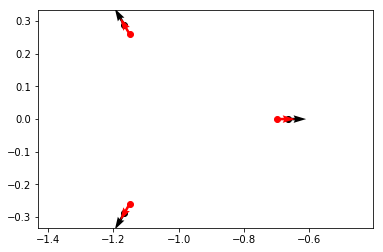

In [98]:
plt.figure()
plt.scatter(scL0_support[:,0], scL0_support[:,1], c='k')
plt.scatter(sc0_support[:,0], sc0_support[:,1], c='r')

plt.quiver(scL0_support[:,0], scL0_support[:,1], scL0_vector[:,0], scL0_vector[:,1], color='k')
plt.quiver(sc0_support[:,0], sc0_support[:,1], sc0_vector[:,0], sc0_vector[:,1], color='r')

plt.axis('equal')
plt.show()

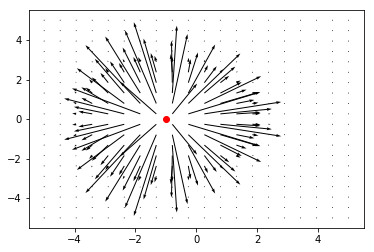

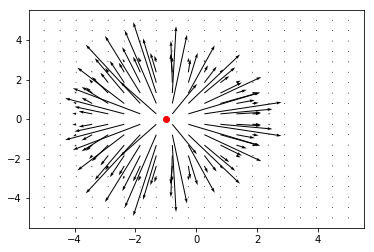

In [106]:
from defmod.usefulfunctions import grid2vec

grid_origin = [-5,-5]
grid_size = [10,10]
grid_resolution = [20,20]
x, y = torch.meshgrid([
    torch.linspace(grid_origin[0], grid_origin[0]+grid_size[0], grid_resolution[0]),
    torch.linspace(grid_origin[1], grid_origin[1]+grid_size[1], grid_resolution[1])])

gridpos = grid2vec(x, y)
gd = scaling0.manifold.gd.view(-1,2).detach().numpy()

def_grid = scaling0.field_generator()(gridpos)
plt.figure()
plt.scatter(gd[:,0], gd[:,1], c='r')
plt.quiver(gridpos.detach()[:,0], gridpos.detach()[:,1], def_grid.detach()[:,0], def_grid.detach()[:,1])
plt.show()


def_grid_L0 = scaling_L0.field_generator()(gridpos)
plt.figure()
plt.scatter(gd[:,0], gd[:,1], c='r')
plt.quiver(gridpos.detach()[:,0], gridpos.detach()[:,1], def_grid_L0.detach()[:,0], def_grid_L0.detach()[:,1])
plt.show()

In [109]:
def_grid - def_grid_L0

tensor([[ 9.0907e-08,  1.5779e-07],
        [ 8.8657e-07,  1.5350e-06],
        [ 6.5374e-06,  1.1239e-05],
        [ 3.6499e-05,  6.1767e-05],
        [ 1.5472e-04,  2.5359e-04],
        [ 5.0044e-04,  7.7143e-04],
        [ 1.2451e-03,  1.7118e-03],
        [ 2.4118e-03,  2.6805e-03],
        [ 3.6947e-03,  2.7121e-03],
        [ 4.5487e-03,  1.1737e-03],
        [ 4.5487e-03, -1.1737e-03],
        [ 3.6947e-03, -2.7121e-03],
        [ 2.4118e-03, -2.6805e-03],
        [ 1.2451e-03, -1.7118e-03],
        [ 5.0044e-04, -7.7143e-04],
        [ 1.5472e-04, -2.5359e-04],
        [ 3.6499e-05, -6.1767e-05],
        [ 6.5374e-06, -1.1239e-05],
        [ 8.8657e-07, -1.5350e-06],
        [ 9.0907e-08, -1.5779e-07],
        [ 5.7462e-07,  9.9616e-07],
        [ 5.5883e-06,  9.6704e-06],
        [ 4.1072e-05,  7.0653e-05],
        [ 2.2841e-04,  3.8744e-04],
        [ 9.6378e-04,  1.5874e-03],
        [ 3.1005e-03,  4.8193e-03],
        [ 7.6673e-03,  1.0676e-02],
        [ 1.4760e-02,  1.669